In [1]:
import numpy as np
import cv2

class Soma:
    """
    Represents the soma (cell body) of a neuron.
    """

    def __init__(self, position, mean_radius, std_radius):
        self.position = position
        self.radius = max(np.random.normal(mean_radius, std_radius), 0)
        self.x_soma, self.y_soma = self._generate_soma()

    def _generate_soma(self):
        theta = np.linspace(0, 2 * np.pi, 100)
        sine_variation = np.random.uniform(0, 15) * np.sin(2 * theta)
        gaussian_variation = np.random.normal(0, 2, len(theta))
        ellipse_ratio = np.random.uniform(0.8, 1.2)
        elongation_angle = np.random.uniform(0, 2 * np.pi)

        x_soma = (self.radius + gaussian_variation + sine_variation) * (
            np.cos(theta) * np.cos(elongation_angle)
            - np.sin(theta) * np.sin(elongation_angle) * ellipse_ratio
        ) + self.position[0]
        y_soma = (self.radius + gaussian_variation + sine_variation) * (
            np.sin(theta) * np.cos(elongation_angle)
            + np.cos(theta) * np.sin(elongation_angle) * ellipse_ratio
        ) + self.position[1]

        return x_soma, y_soma

    def create_binary_mask(self, size=(2048, 2048)):
        """
        Creates both filled and outline binary masks of the soma.

        Args:
            size (tuple): The size of the mask.

        Returns:
            dict: A dictionary containing both filled and outline masks.
        """
        mask_filled = np.zeros(size, dtype=np.uint8)
        mask_outline = np.zeros(size, dtype=np.uint8)
        coordinates = np.array([self.x_soma, self.y_soma]).T.astype(np.int32)

        # Create filled mask
        cv2.fillPoly(mask_filled, [coordinates], 1)

        # Create outline mask
        cv2.polylines(mask_outline, [coordinates], isClosed=True, color=1, thickness=1)

        masks = {
            'filled': mask_filled,
            'outline': mask_outline
        }

        # Do not set x_soma and y_soma to None here

        return masks


In [25]:
import numpy as np
import cv2
import random
from scipy.interpolate import splprep, splev

class Dendrite:
    """
    Represents the dendritic tree of a neuron.
    """

    def __init__(
        self,
        soma,
        depth,
        D,
        branch_angle,
        mean_branches,
        weave_type=None,
        randomness=0.0,
        curviness=None,
        curviness_magnitude=1.0,
        n_primary_dendrites=4,
    ):
        self.soma = soma
        self.depth = depth
        self.D = D
        self.branch_angle = branch_angle
        self.mean_branches = mean_branches
        self.weave_type = weave_type
        self.randomness = randomness
        self.curviness = curviness
        self.curviness_magnitude = curviness_magnitude
        self.n_primary_dendrites = n_primary_dendrites
        self.total_length = self._scale_total_length()
        self.initial_thickness = self._scale_initial_thickness()
        self.branch_lengths = self._generate_branch_lengths()

    def _scale_total_length(self):
        base_length = 40
        length_variation_factor = 5
        total_length = base_length + (self.soma.radius * length_variation_factor) * np.random.uniform(
            0.8, 1.2
        )
        return max(total_length, 0)

    def _generate_branch_lengths(self):
        r = self.mean_branches ** (-1 / self.D)
        branch_lengths = np.zeros(self.depth)
        normalization_factor = self.total_length / sum(r ** i for i in range(self.depth))

        for i in range(self.depth):
            branch_lengths[i] = normalization_factor * r ** i

        return branch_lengths

    def _generate_dendrite_start_points(self):
        start_points = []
        num_soma_points = len(self.soma.x_soma)
        base_indices = np.linspace(0, num_soma_points - 1, self.n_primary_dendrites, endpoint=False).astype(
            int
        )

        random_offsets = np.random.randint(
            -num_soma_points // (100 // self.n_primary_dendrites // 1.5),
            (100 // self.n_primary_dendrites // 1.5) + 1,
            size=self.n_primary_dendrites,
        )
        random_indices = (base_indices + random_offsets) % num_soma_points

        for index in random_indices:
            start_points.append((self.soma.x_soma[index], self.soma.y_soma[index]))

        return start_points

    def _scale_initial_thickness(self):
        base_thickness = 1
        thickness_factor = 0.02
        initial_thickness = base_thickness + thickness_factor * (self.soma.radius + self.total_length)
        return max(initial_thickness, 1)

    def _calculate_thickness(self, distance_from_start, segment_length):
        proportion_start = 1 - (distance_from_start / self.total_length)
        proportion_end = 1 - ((distance_from_start + segment_length) / self.total_length)

        proportion_start = np.clip(proportion_start, 0, 1)
        proportion_end = np.clip(proportion_end, 0, 1)

        thickness_at_start = self.initial_thickness * (proportion_start) ** (1 / self.D)
        thickness_at_end = self.initial_thickness * (proportion_end) ** (1 / self.D)

        thickness_at_start = max(thickness_at_start, 1)
        thickness_at_end = max(thickness_at_end, 1)

        return thickness_at_start, thickness_at_end
    

    def intra_branch_weave(self, x1, y1, x2, y2, length):
        num_points = max(int(self.curviness_magnitude * 10), 2)
        
        # Ensure at least 4 control points
        num_control_points = np.random.randint(4, 7)  # Between 4 and 6 control points
        
        # Generate sorted t values to ensure progression along the branch
        t_values = np.linspace(0.2, 0.8, num_control_points - 2)
        
        # Start with the initial point
        control_x = [x1]
        control_y = [y1]
        
        dx = x2 - x1
        dy = y2 - y1
        branch_angle = np.arctan2(dy, dx)
        
        for t in t_values:
            base_x = x1 + t * dx
            base_y = y1 + t * dy
            
            # Random perturbations perpendicular to the branch direction
            angle = branch_angle + np.pi / 2
            radius = length * np.random.uniform(-0.05, 0.05)  # Reduced to ±5%
            perturb_x = base_x + radius * np.cos(angle)
            perturb_y = base_y + radius * np.sin(angle)
            
            control_x.append(perturb_x)
            control_y.append(perturb_y)
        
        # End with the final point
        control_x.append(x2)
        control_y.append(y2)
        
        # Create a spline through the control points
        tck, u = splprep([control_x, control_y], s=0)
        u_fine = np.linspace(0, 1, num_points)
        xs, ys = splev(u_fine, tck)
        
        # Optional: Add small random perturbations along the spline
        # Ensure that these perturbations are very small to prevent loops
        perturbation_scale = length / 200  # Reduced scale
        if self.curviness == 'Gauss':
            xs += np.random.normal(0, perturbation_scale, num_points)
            ys += np.random.normal(0, perturbation_scale, num_points)
        elif self.curviness == 'Uniform':
            xs += np.random.uniform(-perturbation_scale, perturbation_scale, num_points)
            ys += np.random.uniform(-perturbation_scale, perturbation_scale, num_points)
        
        # Ensure the start and end points are accurate
        xs[0], ys[0] = x1, y1
        xs[-1], ys[-1] = x2, y2
        
        return xs, ys

    
    def _grow_branch(self, x, y, angle, remaining_depth):
        if remaining_depth == 0:
            return None, []

        branch_length = self.branch_lengths[self.depth - remaining_depth]
        sum_length = sum(self.branch_lengths[: self.depth - remaining_depth])

        thickness_start, thickness_end = self._calculate_thickness(sum_length, branch_length)

        if self.weave_type == 'Gauss':
            branch_length *= 1 + np.random.normal(0, self.randomness)
            angle += np.random.normal(0, self.randomness)
        elif self.weave_type == 'Uniform':
            branch_length *= 1 + np.random.uniform(-self.randomness, self.randomness)
            angle += np.random.uniform(-self.randomness, self.randomness)

        end_x = x + branch_length * np.cos(angle)
        end_y = y + branch_length * np.sin(angle)

        weave_x, weave_y = self.intra_branch_weave(x, y, end_x, end_y, branch_length)

        branch_data = {
            'points': np.array([weave_x, weave_y]),
            'length': branch_length,
            'depth': self.depth - remaining_depth,
            'thickness_start': thickness_start,
            'thickness_end': thickness_end,
        }

        num_branches = int(np.clip(np.round(np.random.normal(self.mean_branches, 1)), 1, None))
        new_branches = []

        for i in range(num_branches):
            new_angle = angle + self.branch_angle * (i - (num_branches - 1) / 2)
            if self.weave_type == 'Gauss':
                new_angle += np.random.normal(0, self.randomness)
            elif self.weave_type == 'Uniform':
                new_angle += np.random.uniform(-self.randomness, self.randomness)

            new_branches.append(((end_x, end_y), new_angle))

        return branch_data, new_branches


In [26]:
import numpy as np
import cv2

#from .soma import Soma
#from .dendrite import Dendrite

class Neuron:
    """
    Represents a neuron, consisting of a soma and dendrites.
    """

    def __init__(
        self,
        position,
        depth=5,
        mean_soma_radius=10,
        std_soma_radius=2,
        D=2.0,
        branch_angle=np.pi / 4,
        mean_branches=3,
        weave_type='Gauss',
        randomness=0.1,
        curviness='Gauss',
        curviness_magnitude=1.0,
        n_primary_dendrites=4,
        network=None,
        neuron_id=None,
    ):
        self.network = network
        self.position = position
        self.soma = Soma(position, mean_soma_radius, std_soma_radius)
        self.dendrite = Dendrite(
            self.soma,
            depth,
            D,
            branch_angle,
            mean_branches,
            weave_type,
            randomness,
            curviness,
            curviness_magnitude,
            n_primary_dendrites,
        )

        self.dendrite_mask = np.zeros((network.height, network.width), dtype=np.uint8)
        self.neuron_id = neuron_id
        self.current_depth = 0
        self.branch_ends = []
        self.is_growing = True  # Flag to indicate if the neuron is still growing

    def generate_start_points(self):
        """
        Generates the starting points for the primary dendrites and initializes branch ends.
        """
        start_points = self.dendrite._generate_dendrite_start_points()
        # Initialize branch ends with angles pointing outward from the soma
        for point in start_points:
            dx = point[0] - self.position[0]
            dy = point[1] - self.position[1]
            angle = np.arctan2(dy, dx)
            self.branch_ends.append((point, angle))
        
        # Generate soma masks and store them
        self.soma_masks = self.soma.create_binary_mask(size=(self.network.height, self.network.width))
        
        # After generating start points and masks, discard x_soma and y_soma to free memory
        self.soma.x_soma = None
        self.soma.y_soma = None


    def prepare_next_layer(self):
        """
        Prepare the proposed branches for the next layer without updating the dendrite mask.

        Returns:
            list: Proposed branches for the next layer.
        """
        if self.current_depth >= self.dendrite.depth or not self.branch_ends:
            self.is_growing = False
            return []

        proposed_branches = []

        for start_point, angle in self.branch_ends:
            branch_data, new_branches = self.dendrite._grow_branch(
                start_point[0], start_point[1], angle, self.dendrite.depth - self.current_depth
            )

            if branch_data is not None:
                proposed_branches.append(
                    {
                        'branch_data': branch_data,
                        'start_point': start_point,
                        'new_branches': new_branches,  # Include new branch ends
                    }
                )

        return proposed_branches

    def add_branches(self, accepted_branches):
        """
        Add the accepted branches to the dendrite mask and update branch ends.

        Args:
            accepted_branches (list): List of branches to add.
        """
        new_branch_ends = []

        for branch_info in accepted_branches:
            branch_data = branch_info['branch_data']
            points = branch_data['points']
            new_branches = branch_info['new_branches']

            # Draw the new branch directly onto the mask
            coordinates = np.column_stack((points[0], points[1])).astype(np.int32)
            thicknesses = np.linspace(
                branch_data['thickness_start'],
                branch_data['thickness_end'],
                len(points[0])
            ).astype(int)

            for i in range(len(coordinates) - 1):
                cv2.line(
                    self.dendrite_mask,
                    tuple(coordinates[i]),
                    tuple(coordinates[i + 1]),
                    1,
                    thickness=int(thicknesses[i])
                )

            # After drawing, discard branch_data if not needed
            del branch_data

            # Update branch ends with new branches from accepted branches
            new_branch_ends.extend(new_branches)

        # Update self.branch_ends for the next layer
        self.branch_ends = new_branch_ends

    def draw(self, color, mask_type='filled'):
        """
        Draws the neuron using matplotlib.

        Args:
            color: Color used to draw the neuron.
            mask_type (str): 'filled' or 'outline' to specify which mask to use.
        """
        # Drawing logic can be updated or removed if not needed
        pass

    def generate_binary_mask(self):
        """
        Generates both filled and outline binary masks of the neuron by combining soma and dendrite masks.

        Returns:
            dict: A dictionary containing both filled and outline neuron masks.
        """
        # Use stored soma masks
        soma_masks = self.soma_masks
        
        # Combine masks for both filled and outline versions
        neuron_mask_filled = np.logical_or(soma_masks['filled'], self.dendrite_mask).astype(np.uint8)
        neuron_mask_outline = np.logical_or(soma_masks['outline'], self.dendrite_mask).astype(np.uint8)
        
        # Store the masks
        self.masks = {
            'filled': neuron_mask_filled,
            'outline': neuron_mask_outline
        }
        
        # After generating masks, discard individual masks if not needed
        self.dendrite_mask = None
        self.soma_masks = None  # Discard stored soma masks
        
        return self.masks



In [38]:
import random
import math

def poisson_disk_sampling(width, height, min_distance, num_samples):
    k = 30  # Limit of samples before rejection in the algorithm
    grid_size = min_distance / math.sqrt(2)
    grid_width = int(math.ceil(width / grid_size))
    grid_height = int(math.ceil(height / grid_size))
    grid = [[None for _ in range(grid_height)] for _ in range(grid_width)]
    samples = []
    process_list = []

    # Initial sample
    x = random.uniform(0, width)
    y = random.uniform(0, height)
    samples.append((x, y))
    process_list.append((x, y))
    grid_x = int(x / grid_size)
    grid_y = int(y / grid_size)
    grid[grid_x][grid_y] = (x, y)

    while process_list and len(samples) < num_samples:
        idx = random.randint(0, len(process_list) - 1)
        x, y = process_list[idx]
        found = False
        for _ in range(k):
            angle = random.uniform(0, 2 * math.pi)
            radius = random.uniform(min_distance, 2 * min_distance)
            new_x = x + radius * math.cos(angle)
            new_y = y + radius * math.sin(angle)
            if 0 <= new_x < width and 0 <= new_y < height:
                grid_x = int(new_x / grid_size)
                grid_y = int(new_y / grid_size)
                ok = True
                for i in range(max(grid_x - 2, 0), min(grid_x + 3, grid_width)):
                    for j in range(max(grid_y - 2, 0), min(grid_y + 3, grid_height)):
                        neighbor = grid[i][j]
                        if neighbor is not None:
                            dx = neighbor[0] - new_x
                            dy = neighbor[1] - new_y
                            if dx * dx + dy * dy < min_distance * min_distance:
                                ok = False
                                break
                    if not ok:
                        break
                if ok:
                    samples.append((new_x, new_y))
                    process_list.append((new_x, new_y))
                    grid[grid_x][grid_y] = (new_x, new_y)
                    found = True
                    break
        if not found:
            process_list.pop(idx)
    return samples


In [69]:
def compute_max_buffer_distance(width, height, num_neurons, mean_soma_radius, std_soma_radius, edge_margin):
    """
    Computes the maximum buffer distance that allows num_neurons to fit within the network
    given the mean_soma_radius, std_soma_radius, and fixed edge_margin.
    """
    # Define the maximum soma radius
    max_soma_radius = mean_soma_radius + 2 * std_soma_radius

    # Effective dimensions
    effective_width = width - 2 * edge_margin
    effective_height = height - 2 * edge_margin

    # Set initial search bounds for buffer_distance
    low = 0  # Minimum buffer distance
    # Maximum possible buffer_distance
    high = min(effective_width, effective_height) - 2 * max_soma_radius
    high = max(high, 0)  # Ensure non-negative

    max_buffer_distance = 0

    while low <= high:
        mid = (low + high) // 1  # Current buffer distance to test

        # Calculate min_soma_distance with current buffer_distance
        min_soma_distance = 2 * max_soma_radius + mid

        # Calculate number of cells along each dimension
        num_cells_x = int(effective_width // min_soma_distance)
        num_cells_y = int(effective_height // min_soma_distance)
        total_cells = num_cells_x * num_cells_y

        if num_cells_x > 0 and num_cells_y > 0 and total_cells >= num_neurons:
            # Buffer distance is acceptable, try increasing it
            max_buffer_distance = mid
            low = mid + 1
        else:
            # Buffer distance is too large, decrease it
            high = mid - 1

    return int(max_buffer_distance)


In [71]:
import numpy as np
import cv2
import xarray as xr

#from .neuron import Neuron

class Network:
    """
    Represents a network of neurons.
    """

    def __init__(self, width, height, num_neurons, neuron_params, edge_margin=100, network_id = None):
        self.width = width
        self.height = height
        self.num_neurons = num_neurons
        self.neuron_params = neuron_params
        self.neurons = []
        self.network_mask = np.zeros((self.height, self.width), dtype=np.uint8)
        self.somas_mask = np.zeros((self.height, self.width), dtype=np.uint8)
        self.network_id = network_id
        self.edge_margin = edge_margin  # Fixed edge margin of 100 pixels

        # Define neuron size parameters
        mean_soma_radius = neuron_params['mean_soma_radius']
        std_soma_radius = neuron_params['std_soma_radius']

        # Compute max_soma_radius
        max_soma_radius = mean_soma_radius + 2 * std_soma_radius

        # Compute max buffer distance
        self.buffer_distance = compute_max_buffer_distance(
            width=self.width,
            height=self.height,
            num_neurons=self.num_neurons,
            mean_soma_radius=mean_soma_radius,
            std_soma_radius=std_soma_radius,
            edge_margin=self.edge_margin
        )

        # Now, with buffer_distance, compute min_soma_distance
        self.min_soma_distance = 2 * max_soma_radius + self.buffer_distance

    def seed_neurons(self):
        """
        Seeds neurons in the network using grid-based placement with random jitter,
        ensuring they are within the fixed edge margin.
        """
        cell_size = self.min_soma_distance

        # Effective dimensions considering the edge margin
        effective_width = self.width - 2 * self.edge_margin
        effective_height = self.height - 2 * self.edge_margin

        num_cells_x = int(effective_width // cell_size)
        num_cells_y = int(effective_height // cell_size)
        total_cells = num_cells_x * num_cells_y

        if self.num_neurons > total_cells:
            raise ValueError("Cannot place all neurons with the given parameters. Adjust neuron size or number.")

        # Generate all possible grid cell indices within the safe area
        grid_indices = [(i, j) for i in range(num_cells_x) for j in range(num_cells_y)]
        # Randomly select cells to place neurons
        selected_cells = random.sample(grid_indices, self.num_neurons)

        for neuron_index, (i, j) in enumerate(selected_cells):
            neuron_id = f"{self.network_id}_neuron_{neuron_index + 1}"
            cell_x = i * cell_size + self.edge_margin
            cell_y = j * cell_size + self.edge_margin

            # Random jitter within the cell, ensuring the neuron stays within bounds
            soma_radius = max(
                self.neuron_params['mean_soma_radius'] + 2 * self.neuron_params['std_soma_radius'], 1
            )
            max_jitter_x = min(cell_size - 2 * soma_radius, effective_width - i * cell_size - 2 * soma_radius)
            max_jitter_y = min(cell_size - 2 * soma_radius, effective_height - j * cell_size - 2 * soma_radius)
            if max_jitter_x < 0 or max_jitter_y < 0:
                raise ValueError("Cell size is too small for the soma size. Adjust neuron parameters.")

            neuron_x = cell_x + soma_radius + random.uniform(0, max_jitter_x)
            neuron_y = cell_y + soma_radius + random.uniform(0, max_jitter_y)
            position = (neuron_x, neuron_y)

            neuron = Neuron(
                position,
                **self.neuron_params,
                network=self,
                neuron_id=neuron_id
            )

            # Create a binary mask of the soma
            neuron.soma_masks = neuron.soma.create_binary_mask(size=(self.height, self.width))
            new_soma_mask = neuron.soma_masks['filled']

            # Add neuron to the network
            self.neurons.append(neuron)
            self.somas_mask = np.logical_or(self.somas_mask, new_soma_mask).astype(np.uint8)
            neuron.generate_start_points()

    def grow_network(self):
        """
        Grows the dendrites of all neurons in the network layer by layer.
        """
        growing = True
        while growing:
            growing = False
            for neuron in self.neurons:
                if neuron.is_growing:
                    proposed_branches = neuron.prepare_next_layer()
                    if proposed_branches:
                        neuron.add_branches(proposed_branches)
                        growing = True
                    else:
                        neuron.is_growing = False

            # Increment the current depth for all neurons
            for neuron in self.neurons:
                if neuron.is_growing:
                    neuron.current_depth += 1

    def generate_binary_mask(self):
        """
        Generates both filled and outline binary masks of the entire network by combining neuron masks.

        Returns:
            dict: A dictionary containing both filled and outline network masks.
        """
        network_mask_filled = np.zeros((self.height, self.width), dtype=np.uint8)
        network_mask_outline = np.zeros((self.height, self.width), dtype=np.uint8)

        for neuron in self.neurons:
            neuron_masks = neuron.generate_binary_mask()

            network_mask_filled = np.logical_or(network_mask_filled, neuron_masks['filled']).astype(np.uint8)
            network_mask_outline = np.logical_or(network_mask_outline, neuron_masks['outline']).astype(np.uint8)

            # After processing, discard neuron's individual masks to free memory
            neuron.masks = None

        self.masks = {
            'filled': network_mask_filled,
            'outline': network_mask_outline
        }

        return self.masks


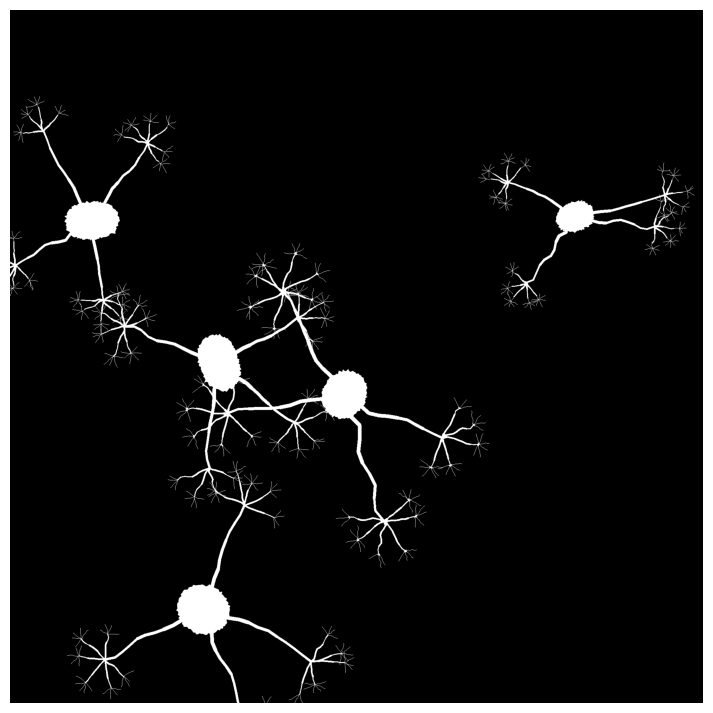

In [83]:
# Define neuron parameters
neuron_params = {
    'depth': 3,
    'mean_soma_radius': 65,
    'std_soma_radius': 5,
    'D': 1.5,
    'branch_angle': np.pi / 4,
    'mean_branches': 5,
    'weave_type': 'Gauss',
    'randomness': 0.1,
    'curviness': 'Gauss',
    'curviness_magnitude': 1,
    'n_primary_dendrites': 4,
}

# Calculate minimum distance between somas
max_soma_radius = neuron_params['mean_soma_radius'] + 2 * neuron_params['std_soma_radius']
buffer_distance = 100  # Adjust as needed
min_soma_distance = 2 * max_soma_radius + buffer_distance

# Define edge margin
edge_margin = 100  # Ensure neurons are at least 200 pixels from the edge

# Create a network
network = Network(width=2048, height=2048, num_neurons=5, neuron_params=neuron_params, edge_margin=edge_margin)

# Seed neurons
network.seed_neurons()

# Grow network
network.grow_network()

# Generate binary masks
network_masks = network.generate_binary_mask()

import matplotlib.pyplot as plt

plt.figure(figsize=(9,9))
plt.imshow(network_masks['filled'], cmap = 'gray')
plt.axis(False);
# Optionally, create a dataset
#dataset = network.create_dataset()


In [ ]:
### GRAVEYARD

'''
    def intra_branch_weave(self, x1, y1, x2, y2, length):
        num_points = max(int(self.curviness_magnitude * 10), 2)
        xs = np.linspace(x1, x2, num_points)
        ys = np.linspace(y1, y2, num_points)

        if self.curviness == 'Gauss':
            perturb_xs = xs + (length / 50) * np.random.normal(0, 1, num_points)
            perturb_ys = ys + (length / 50) * np.random.normal(0, 1, num_points)
        elif self.curviness == 'Uniform':
            perturb_xs = xs + (length / 50) * np.random.uniform(-1, 1, num_points)
            perturb_ys = ys + (length / 50) * np.random.uniform(-1, 1, num_points)
        else:
            perturb_xs = xs
            perturb_ys = ys

        perturb_xs[0], perturb_ys[0] = x1, y1
        perturb_xs[-1], perturb_ys[-1] = x2, y2

        return perturb_xs, perturb_ys
'''

class Network:
    """
    Represents a network of neurons.
    """

    def __init__(self, width, height, num_neurons, neuron_params, network_id):
        self.width = width
        self.height = height
        self.num_neurons = num_neurons
        self.neuron_params = neuron_params
        self.neurons = []
        self.network_mask = np.zeros((self.height, self.width), dtype=np.uint8)
        self.somas_mask = np.zeros((self.height, self.width), dtype=np.uint8)
        self.network_id = network_id

    def seed_neurons(self):
        """
        Seeds neurons in the network, ensuring that no two somas overlap.
        """
        for neuron_index in range(self.num_neurons):
            max_attempts = 100
            attempts = 0

            while attempts < max_attempts:
                position = (np.random.uniform(0, self.width), np.random.uniform(0, self.height))
                neuron_id = f"{self.network_id}_neuron_{neuron_index + 1}"

                neuron = Neuron(
                    position,
                    **self.neuron_params,
                    network=self,
                    neuron_id=neuron_id
                )

                # Create a binary mask of the soma
                soma_masks = neuron.soma.create_binary_mask(size=(self.height, self.width))
                new_soma_mask = soma_masks['filled']

                # Check for overlap
                overlap = np.any(np.logical_and(self.somas_mask, new_soma_mask))

                if not overlap:
                    # Add neuron to the network
                    self.neurons.append(neuron)
                    self.somas_mask = np.logical_or(self.somas_mask, new_soma_mask).astype(np.uint8)
                    neuron.generate_start_points()
                    break

                attempts += 1

            if attempts == max_attempts:
                print(
                    f"Warning: Could not place neuron {neuron_index + 1} without overlap after {max_attempts} attempts."
                )

class Network:
    """
    Represents a network of neurons.
    """

    def __init__(self, width, height, num_neurons, neuron_params, min_soma_distance, network_id=None):
        self.width = width
        self.height = height
        self.num_neurons = num_neurons
        self.neuron_params = neuron_params
        self.neurons = []
        self.network_mask = np.zeros((self.height, self.width), dtype=np.uint8)
        self.somas_mask = np.zeros((self.height, self.width), dtype=np.uint8)
        self.network_id = network_id
        self.min_soma_distance = min_soma_distance  # New parameter

    def seed_neurons(self):
        """
        Seeds neurons in the network, ensuring that no two somas overlap and are adequately spaced.
        """
        # Generate soma positions using Poisson disk sampling
        positions = poisson_disk_sampling(
            width=self.width,
            height=self.height,
            min_distance=self.min_soma_distance,
            num_samples=self.num_neurons
        )

        # Check if enough positions were generated
        if len(positions) < self.num_neurons:
            print(f"Warning: Could only place {len(positions)} neurons with the given minimum distance.")
            self.num_neurons = len(positions)

        for neuron_index, position in enumerate(positions):
            neuron_id = f"{self.network_id}_neuron_{neuron_index + 1}"

            neuron = Neuron(
                position,
                **self.neuron_params,
                network=self,
                neuron_id=neuron_id
            )

            # Create a binary mask of the soma
            soma_masks = neuron.soma.create_binary_mask(size=(self.height, self.width))
            new_soma_mask = soma_masks['filled']

            # Add neuron to the network
            self.neurons.append(neuron)
            self.somas_mask = np.logical_or(self.somas_mask, new_soma_mask).astype(np.uint8)
            neuron.generate_start_points()